In [13]:
import logging

#init logging
log_level = logging.INFO
logging.basicConfig(level=log_level,
        format="%(asctime)s.%(msecs)03d [%(levelname)s] [%(module)s] %(message)s", datefmt="%H:%M:%S")

ALL_VULS = ['Underflow','Overflow','Multisig','CallDepth','TOD','TimeDep','Reentracy','AssertFail',
            'TxOrigin','CheckEffects','InlineAssembly','BlockTimestamp','LowlevelCalls','BlockHash','SelfDestruct']



## Data

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DEF_DATAFILE = 'data-cache.csv'

def newer(f1, f2):
    return os.path.getmtime(f1) > os.path.getmtime(f2)

# be careful, it's no easy way to check if vol + ft = data,
# we just check if cache data is newer than vol and ft
def getData(volfile, ftfile, reload=False):

    if not reload and os.path.exists(DEF_DATAFILE) \
            and newer(DEF_DATAFILE, volfile) and newer(DEF_DATAFILE, ftfile):

        logging.info("Loading the cached data '%s'" % DEF_DATAFILE);
        data = pd.read_csv(DEF_DATAFILE, index_col=0)
    else:
        logging.info("Creating the data...")

        y_mapping = {'r': 1, 'o': 1, 'x': 0}

        data = pd.merge(
                left_index=True,
                left=pd.read_csv(volfile, index_col=0).replace(y_mapping),
                right_index=True,
                right=pd.read_csv(ftfile, index_col=0),
                how='inner')
        data.drop_duplicates(inplace=True)
        logging.info("Saving the data to '%s'" % DEF_DATAFILE);
        data.to_csv(DEF_DATAFILE)

    return data

# prepare data
data = getData('vols.csv', 'ft.csv')

10:25:52.014 [INFO] [<ipython-input-3-5b546898050e>] Loading the cached data 'data-cache.csv'


In [12]:
data.shape

(17979, 16)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

def stratifiedSplit(df, colname):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in split.split(df, df[colname]):
        return df.iloc[train_idx], df.iloc[test_idx]

def splitData(data, volname):
    #train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
    train_set, test_set = stratifiedSplit(data, volname)

    X_train = train_set['Opcodes'].values
    y_train = train_set[volname].values
    X_test = test_set['Opcodes'].values
    y_test = test_set[volname].values

    return X_train, y_train, X_test, y_test

__vulname = vul = 'TOD'
data_sets = splitData(data, vul)

## HyperparamKeeper

In [458]:
import os
import pandas as pd

class HyperparamKeeper:
    
    @property
    def df(self):
        self.__check_dirty()
        return self.__params
    
    def __init__(self, filename, cols, convs=None):
        self.__fname = filename
        self.__params = pd.read_csv(self.__fname, index_col=0, converters=convs) if os.path.exists(self.__fname) else\
                        pd.DataFrame([], columns=cols)
        self.__dirty = False
        
    def __str__(self):
        return str(self.__params)
    
    def __check_dirty(self):
        if self.__dirty:
            self.__params.drop_duplicates(inplace=True)
            self.__dirty = False
    
    def __check_pm_name(self, pm, target=None):
        if target is None:
            target = self.__params.columns
        
        if len(pm) != len(target):
            return False
        
        for name in pm:
            if name not in target:
                logging.warning("The parameter name '%s' is not allowed" % name)
                return False
        return True
    
    def __assert_pm_name(self, pm, target=None):
        if not self.__check_pm_name(pm, target):
            raise Exception('Not matched param columns')
            
    def __cond(self, pm):
        for i, (p, v) in enumerate(pm.items()):
            if i == 0:
                cond = (self.__params[p] == v)
            else:
                cond &= (self.__params[p] == v)
        return cond
        
    def __dup_params(self, pm):
        self.__assert_pm_name(pm, self.__params.columns[:-1])
        return self.__params[self.__cond(pm)]

    
    def is_dup(self, pm):
        return not self.__dup_params(pm).empty

    
    def add(self, pm, ifdup='update'):
        self.__assert_pm_name(pm)
        self.__params.loc[len(self.__params)] = pm
        self.__dirty = True

    def save(self):
        self.__check_dirty()
        self.__params.to_csv(self.__fname)
    
    # put new item and return (new) dict
    @staticmethod
    def __put(d, k, v, inplace=False):
        if not inplace:
            d = d.copy()
        d[k] = v
        return d

    # return the list of pm generated form meta[idx:]
    # @pm is a dict of paramter/value
    @classmethod
    def __gen(cls, meta, idx):
        if idx >= len(meta):
            return [{}]  # empty pm

        p, vals = meta[idx]

        # 'inplace' is not necessary, just for dict reuse
        return [ cls.__put(pm, p, v, inplace=(i==0)) \
                    for pm in cls.__gen(meta, idx + 1) \
                        for i, v in enumerate(vals) ]

    @classmethod    
    def __split_pm_temp(cls, pm_temp):
        meta = {}
        rec = {}
        for p, val in pm_temp.items():
            if isinstance(val, list):
                meta[p] = val
            else:
                rec[p] = val
        return meta, rec
   
       
    
    # @pm_rec: not 'score' and not 'meta'
    # return best score and its meta param
    def best_param(self, pm_rec):
        score_col = self.__params.columns[-1] #last column is core column
        calidates = self.__params[self.__cond(pm_rec)][score_col]
        if calidates.empty:
            return None, None
        best = calidates.idxmax()
        best_pm = dict(self.__params.iloc[best].items())
        
        score = best_pm.pop(score_col)
        for p in pm_rec:
            del best_pm[p]
            
        return best_pm, score

    # @pm_temp: parameter template: contain 'meta' (list) and 'rec' (normal), without 'score' column
    # flaten params and skim the duplicatd params, according to @pm_temp
    def gen_params(self, pm_temp, by='nodup'):
 
        # extract meta parameter from template
        meta, rec = self.__split_pm_temp(pm_temp)
                
        def listify(pm):
            for p in meta:
                v = pm[p]
                pm[p] = [v]
            return pm
        
        metas = []
        for m in self.__gen(list(meta.items()), 0):            
            if not self.is_dup({**m, **rec}):
                metas.append(listify(m))
                
        return metas

        '''
        # a trivial version of __gen(meta,0) is like below, if len(meta) is fixed to 4:
        p1, p2, p3, p4 = meta                
        for v1 in pm_meta[p1]:
            for v2 in pm_meta[p2]:
                for v3 in pm_meta[p3]:
                    for v4 in pm_meta[p4]:
                        pm = {p1: v1, p2: v2, p3: v3, p4: v4}
        '''
    
if __name__ == '__main__':
    import logging
    logging.basicConfig(level=logging.INFO,
            format="%(asctime)s.%(msecs)03d [%(levelname)s] [%(module)s] %(message)s", datefmt="%H:%M:%S")



cols = ('data__label', 'data__size', 'vect__ngram_range', 'vect__max_df', 'clf__penalty', 'clf__C', 'cv__fold', 'cv__scoring', 'cv__score')
hyparams = HyperparamKeeper('.params', cols)
hyparams.df

,data__label,data__size,vect__ngram_range,vect__max_df,clf__penalty,clf__C,cv__fold,cv__scoring,cv__score
0,TOD,14383,"(1, 1)",0.5,l1,30.0,2,recall,0.133969
1,TOD,14383,"(2, 2)",0.5,l1,30.0,2,recall,0.498315
2,TOD,14383,"(3, 3)",0.5,l1,30.0,2,recall,0.666026
3,TOD,14383,"(4, 4)",0.5,l1,30.0,2,recall,0.741688
4,TOD,14383,"(1, 1)",0.7,l1,30.0,2,recall,0.120475
5,TOD,14383,"(2, 2)",0.7,l1,30.0,2,recall,0.502656
6,TOD,14383,"(3, 3)",0.7,l1,30.0,2,recall,0.672290
7,TOD,14383,"(4, 4)",0.7,l1,30.0,2,recall,0.742170
8,TOD,14383,"(5, 5)",0.5,l1,30.0,2,recall,0.759995
9,TOD,14383,"(5, 5)",0.7,l1,30.0,2,recall,0.762888


In [459]:
pm_meta = {
    'clf__C': [30.0],
    'clf__penalty': ['l1'],
    'vect__max_df': [0.5, 0.7],
    'vect__ngram_range': [(1,1), (2,2), (3, 3), (4,4), (5,5), (99,99)],
}
pm_rec = {
    'data__label': 'TOD',
    'data__size': 14383,
    'cv__fold': 2,
    'cv__scoring': 'recall',
    }
pm_temp = {**pm_meta, **pm_rec}

hyparams.gen_params(pm_temp)



[{'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.5],
  'vect__ngram_range': [(1, 1)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.5],
  'vect__ngram_range': [(2, 2)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.5],
  'vect__ngram_range': [(3, 3)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.5],
  'vect__ngram_range': [(4, 4)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.5],
  'vect__ngram_range': [(5, 5)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.5],
  'vect__ngram_range': [(99, 99)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.7],
  'vect__ngram_range': [(1, 1)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.7],
  'vect__ngram_range': [(2, 2)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect__max_df': [0.7],
  'vect__ngram_range': [(3, 3)]},
 {'clf__C': [30.0],
  'clf__penalty': ['l1'],
  'vect

In [460]:
pm_rec = {
    #'data__label': 'TOD',
    'data__size': 14383,
    'cv__fold': 5,
    'cv__scoring': 'recall',
    }
for vul in ALL_VULS:
    pm_rec['data__label'] = vul
    param, score = hyparams.best_param(pm_rec)
    print('best for ', vul)
    print('  score: ', score)
    print('  param: ', param)


best for  Underflow
  score:  0.9944989837551056
  param:  {'clf__penalty': 'l1', 'clf__C': 30.0, 'vect__ngram_range': '(1, 1)', 'vect__max_df': 0.5}
best for  Overflow
  score:  1.0
  param:  {'clf__penalty': 'l1', 'clf__C': 30.0, 'vect__ngram_range': '(1, 1)', 'vect__max_df': 0.5}
best for  Multisig
  score:  None
  param:  None
best for  CallDepth
  score:  0.757933600386496
  param:  {'clf__penalty': 'l1', 'clf__C': 100.0, 'vect__ngram_range': '(4, 4)', 'vect__max_df': 0.7}
best for  TOD
  score:  0.8038586383355852
  param:  {'clf__penalty': 'l1', 'clf__C': 100.0, 'vect__ngram_range': '(5, 5)', 'vect__max_df': 0.5}
best for  TimeDep
  score:  0.7138982081697317
  param:  {'clf__penalty': 'l1', 'clf__C': 100.0, 'vect__ngram_range': '(5, 5)', 'vect__max_df': 0.5}
best for  Reentracy
  score:  0.8085548890604524
  param:  {'clf__penalty': 'l1', 'clf__C': 100.0, 'vect__ngram_range': '(5, 5)', 'vect__max_df': 0.5}
best for  AssertFail
  score:  0.9234255886718212
  param:  {'clf__penal

## Cross Velidation

In [599]:
from pprint import pformat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# the CV who remembers its historic tained hyperparameters
# TODO using Template Desing Pattern to split underlying cv and logic
class MemoCV:
    @property
    def scoring(self):
        return self.__scoring

    @property
    def fold(self):
        return self.__fold

    def __init__(self, file_params, scoring, fold):
        cols = ('data__label', 'data__size', 'vect__ngram_range', 'vect__max_df', 'clf__penalty', 'clf__C', 'cv__fold', 'cv__scoring', 'cv__score')    
        self.__hyparams = HyperparamKeeper(file_params, cols, {"vect__ngram_range": eval})

        self.__scoring = scoring
        self.__fold = fold

    @classmethod
    def __get_pipe_model(cls, pipe, name):
        for n, m in pipe.steps:
            if n == name:
                return m
        return None

    @classmethod
    def __extract_pm(cls, pipe):
        if pipe is None:
            return None
        
        vect = cls.__get_pipe_model(pipe, 'vect')
        clf = cls.__get_pipe_model(pipe, 'clf')
        
        return {
            'clf__C': clf.C,
            'clf__penalty': clf.penalty,
            'vect__max_df': vect.max_df,
            'vect__ngram_range': vect.ngram_range
        }

    @classmethod
    def __import_pm(cls, pipe, pm, vect=None, clf=None):
        if vect is None:
            vect = cls.__get_pipe_model(pipe, 'vect')
        if clf is None:
            clf = cls.__get_pipe_model(pipe, 'clf')
        
        vect.ngram_range = pm['vect__ngram_range']
        vect.max_df = pm['vect__max_df']
        clf.C = pm['clf__C']
        clf.penalty = pm['clf__penalty']
        
    @staticmethod
    def tokenizer(text):
        return text.split()

    @classmethod
    def __get_raw_model(cls, init_pm=None):
        vect = TfidfVectorizer(strip_accents=None,
                lowercase=False,
                preprocessor=None,
                stop_words=None, #const.STOP_WORDS,
                tokenizer=cls.tokenizer)

        clf = LogisticRegression(random_state=0)
        
        if init_pm is not None:
            cls.__import_pm(None, init_pm, vect, clf)
            
        return Pipeline([('vect', vect),
                         ('std', StandardScaler(with_mean=False)),
                         ('clf', clf)])

        
    # @labelname is 
    def fit(self, X, y, pm_meta, label):
        # get untrained hyperparameters
        pm_rec = {
         'cv__fold': self.__fold,
         'cv__scoring': self.__scoring,
         'data__size': len(X),
         'data__label': label
        }

        pm_temp = { **pm_meta, **pm_rec}        
        params = self.__hyparams.gen_params(pm_temp)

        if params:
            model = self.__get_raw_model()
            cv = GridSearchCV(model, params,
                scoring=self.__scoring,
                cv=self.__fold,
                verbose=1,
                n_jobs=-1,
                return_train_score=True)

            cv.fit(X, y)          
            

            #save hyperparameters 
            for score, std, pm in zip(cv.cv_results_['mean_test_score'], cv.cv_results_['std_test_score'], cv.cv_results_['params']):
                logging.info('score: %f, std: %f' % (score, std))
                pm = {**pm, **pm_rec}
                pm['cv__score'] = score                
                self.__hyparams.add(pm)
            self.__hyparams.save()
         
            # trained model
            cv_model = cv.best_estimator_
        else:
            cv_model = None
            logging.debug('All possbiles hyperparameters are trained: \n%s' % pformat(pm_temp))
        
        # get best params from @pm_temp    
        best_pm, best_score = self.__hyparams.best_param(pm_rec)
        logging.info('[MemoCV] CV(%s,%d), Best Score: %f, Best parameter: \n%s' % 
                     (self.__scoring, self.__fold, best_score, pformat(best_pm)))
       
        # return the model from best params
        if self.__extract_pm(cv_model) == best_pm: # optimize for the lucky case
            return cv_model
        else:
            logging.info('[MemoCV] Instaniate model from the best param')
            model = self.__get_raw_model(best_pm)
            model.fit(X, y)
            return model


## Train

In [601]:



def train(X_train, y_train, vulname):
    logging.info('[Train] Traiing...')

    # data
    #X_train, y_train, X_test, y_test = data_sets

    # train
    pm_meta = {
            'clf__C': [30.0, 100.0],
            'clf__penalty': ['l1', 'l2'],
            'vect__max_df': [0.5, 0.7],
            'vect__ngram_range': [(1,1),(2,2),(3,3),(4,4),(5,5)]}
    #'vect__stop_words': [stop, None],
    #'vect__tokenizer': [tokenizer, tokenizer_porter],
    #'vect__use_idf':[False],
    #'vect__norm':[None],
    cv = MemoCV('.params', 'f1', 5)
    model = cv.fit(X_train, y_train, pm_meta, vulname)

    #logging.info('[Train] Test %s: %.3f' % (cv.scoring, model.score(X_test, y_test)))
    return model


## Inflence

### samples 

In [356]:
import numpy as np    
from sklearn.linear_model import LogisticRegression

x1 = np.random.randn(100)
x2 = 4*np.random.randn(100)
x3 = 0.5*np.random.randn(100)
y = (3 + x1 + x2 + x3 + 0.2*np.random.randn()) > 0
X = np.column_stack([x1, x2, x3])

m = LogisticRegression()
m.fit(X, y)

# The estimated coefficients will all be around 1:
print(m.coef_)

# Those values, however, will show that the second parameter
# is more influential
print(np.std(X, 0)*m.coef_)

[[0.8588281  1.02663702 1.25686231]]
[[0.78973913 3.54183066 0.61152417]]


### calculate influence

In [589]:
def calc_influence(model, X):
    vect = model.steps[0][1]
    clf = model.steps[-1][1]
    
    X_ft = vect.transform(X)
    #X_ft_std = [np.std(X_ft.getcol(i).toarray()) \
    #           for i in range(X_ft.shape[1]) ]
    X_ft_std = np.ones(X_ft.shape[1])

    df = pd.DataFrame({'feature': vect.get_feature_names(),
                   'ft_std': X_ft_std,
                   'coef': clf.coef_[0]
                  },
                  columns=['feature', 'ft_std', 'coef'])


    df['influence'] = df['coef'] * df['ft_std']
    df.sort_values(by='influence', ascending=False, inplace=True)
    return df


In [448]:
df = calc_influence(model, X_train)
df.head()

,feature,ft_std,coef,influence
74895,SUB ADD ADD SHA3 CALLER,0.049506,26.758043,1.324685
12721,ADDRESS BALANCE SUB CALL REVERT,0.022196,39.836806,0.884213
45521,REVERT ADDRESS BALANCE SUB CALL,0.017675,44.851419,0.792757
6222,ADD SHA3 CALLER SUB CALL,0.016163,37.974865,0.613797
53930,REVERT SUB CALLER REVERT SELFDESTRUCT,0.007660,75.409057,0.577609


## evaluate

In [546]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

    
def evaluate(model, X, y):
    y_pred = model.predict(X)

    total = len(X)
    accu = accuracy_score(y, y_pred)
    [p], [r], [f], [s] = precision_recall_fscore_support(y, y_pred, labels=[1])
    s /= total
    score = total, s, accu, p, r, f
    logging.info('[EVAL]size %d, support %.3f, accuracy %.3f, precision %.3f, recall %.3f, fscore %.3f' % score)
    
    #score_s = pd.Series(score, index=['Size', 'Support', 'Accuracy', 'Precision', 'Recall', 'F1'])    
    return score
    

    


In [547]:
score = evaluate(model, X_test, y_test)
score



15:32:23.797 [INFO] [<ipython-input-546-62ed976c03d5>] [EVAL]size 3596, support 0.891, accuracy 0.891, precision 0.891, recall 1.000, fscore 0.942


(3596,
 0.8907119021134594,
 0.8907119021134594,
 0.8907119021134594,
 1.0,
 0.9421973819679365)

## Main

In [656]:
results = pd.DataFrame({}, columns=['vul',
        'train_size', 'train_support', 'train_accuracy', 'train_precision', 'train_recall', 'train_f1',
        'test_size', 'test_support', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1',
        'top_ft_1', 'top_inf_1', 'top_ft_2', 'top_inf_2','top_ft_3', 'top_inf_3'])

for vul in ['BlockTimestamp']:#ALL_VULS:
    if (data[vul] == 1).sum() < 2:    #no enough sample to be grouped and train
        #scores.append((zero,zero))
        continue

    logging.info('[%s] Training ===================' % vul)
    X_train, y_train, X_test, y_test = splitData(data, vul)
    model = train(X_train, y_train, vul)
    
    influence = calc_influence(model, X_train)
    top3_inf_fts = influence[['feature', 'influence']].head(n=3).values.reshape(6)
    logging.info('Influence:\n%s\n...\n%s' % (influence.head(), influence.tail()))
    
    score_train = evaluate(model, X_train, y_train)
    score_test = evaluate(model, X_test, y_test)
    
    results.loc[len(results)] = [vul, *score_train, *score_test, *top3_inf_fts]
    


results.set_index('vul', inplace=True)
results

15:23:32.303 [INFO] [<ipython-input-656-cee08fb451f6>] [BlockTimestamp] Training ===================
15:23:32.344 [INFO] [<ipython-input-601-3bae02751801>] [Train] Traiing...


Exception: Not matched param columns

In [538]:

results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, Overflow to Overflow
Data columns (total 18 columns):
train_size         1 non-null float64
train_support      1 non-null float64
train_accuracy     1 non-null float64
train_precision    1 non-null float64
train_recall       1 non-null float64
train_f1           1 non-null float64
test_size          1 non-null float64
test_support       1 non-null float64
test_accuracy      1 non-null float64
test_precision     1 non-null float64
test_recall        1 non-null float64
test_f1            1 non-null float64
top_ft_1           1 non-null object
top_inf_1          1 non-null float64
top_ft_2           1 non-null object
top_inf_2          1 non-null float64
top_ft_3           1 non-null object
top_inf_3          1 non-null float64
dtypes: float64(15), object(3)
memory usage: 152.0+ bytes


## XXX

In [619]:
model

from sklearn.metrics import confusion_matrix

y_test_pred = model.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[ 302,   91],
       [  63, 3140]])

In [628]:
a  = {'b': 1, 'a': 2}
title = sorted(a.keys())
['task_name', *title]

['task_name', 'a', 'b']

In [630]:
pm_grid = {
         'clf__C': [30.0],
         'clf__penalty': ['l1'],
         'vect__max_df': [0.5, 0.7],
         'vect__ngram_range': [(1,1), (2,2), (3, 3), (4,4), (5,5), (99,99)],
         }
convs = {p:eval for p, v in pm_grid.items() if isinstance(v[0], tuple)}
convs

{'vect__ngram_range': <function eval>}

In [575]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


vect = TfidfVectorizer(strip_accents=None,
                lowercase=False,
                preprocessor=None,
                stop_words=None, #const.STOP_WORDS,
                tokenizer=MemoCV.tokenizer,
                ngram_range=(1,1),
                max_df=0.7)


data_std = Pipeline([
    ('vect', vect),
    ('std', StandardScaler(with_mean=False))
])

In [576]:
X_std = data_std.fit_transform(X_train)

In [635]:
a = list(df.columns)
del a[-1]
a


['feature', 'ft_std', 'coef']

In [642]:
data.head().iloc[:,-1]

Addr
0x0000000000b3F879cb30FE243b4Dfee438691c04    CALLDATASIZE CALLDATALOAD REVERT CALLVALUE REV...
0x000000002647e16d9bab9e46604d75591d289277    CALLDATASIZE CALLDATALOAD REVERT CALLVALUE REV...
0x000000002bb43c83ece652d161ad0fa862129a2c    CALLDATASIZE CALLDATALOAD REVERT CALLVALUE REV...
0x000000005fbe2cc9b1b684ec445caf176042348e    CALLDATASIZE CALLDATALOAD REVERT CALLVALUE REV...
0x0006157838d5a6b33ab66588a6a693a57c869999                                          REVERT SHA3
Name: Opcodes, dtype: object

In [578]:
a = X_std.toarray()
vect.get_feature_names()

['BALANCE',
 'BLOCKHASH',
 'CALLCODE',
 'CALLDATACOPY',
 'CODECOPY',
 'CODESIZE',
 'COINBASE',
 'CREATE',
 'DELEGATECALL',
 'DIFFICULTY',
 'EXTCODECOPY',
 'EXTCODESIZE',
 'GAS',
 'GASLIMIT',
 'GASPRICE',
 'NUMBER',
 'ORIGIN',
 'SELFDESTRUCT',
 'TIMESTAMP']

In [594]:
a = [1, 2, 3]
b = [4, 5, 6]
c = [7, 8, 9]

for x1, x2, x3 in zip(a, b, c):
    print(x1, x2, x3)

1 4 7
2 5 8
3 6 9


In [602]:
from sklearn.externals import joblib
joblib.dump(model, "xxx_model.pkl")
# and later...
xxx_model = joblib.load("xxx_model.pkl")

In [603]:
type(xxx_model)

sklearn.pipeline.Pipeline

In [613]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17979 entries, 0x0000000000b3F879cb30FE243b4Dfee438691c04 to 0xfffeee1655f36233fd58fdda74720b4eb85fddec
Data columns (total 16 columns):
Underflow         17979 non-null int64
Overflow          17979 non-null int64
Multisig          17979 non-null int64
CallDepth         17979 non-null int64
TOD               17979 non-null int64
TimeDep           17979 non-null int64
Reentracy         17979 non-null int64
AssertFail        17979 non-null int64
TxOrigin          17979 non-null int64
CheckEffects      17979 non-null int64
InlineAssembly    17979 non-null int64
BlockTimestamp    17979 non-null int64
LowlevelCalls     17979 non-null int64
BlockHash         17979 non-null int64
SelfDestruct      17979 non-null int64
Opcodes           17979 non-null object
dtypes: int64(15), object(1)
memory usage: 3.0+ MB


In [649]:
from sklearn.metrics import confusion_matrix

time_dep = data['TimeDep']
blk_ts = data['BlockTimestamp']
confusion_matrix(time_dep, blk_ts)


array([[12100,  4651],
       [    0,  1228]])

In [650]:
from sklearn.metrics import confusion_matrix

confusion_matrix(data['Reentracy'], data['CheckEffects'])

array([[10728,  6696],
       [   68,   487]])

In [659]:
y_train_pred = model.predict(X_train)


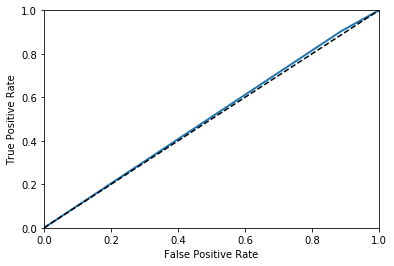

In [661]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [663]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.5084628591210464

In [669]:
a = [('name', 2), ('name2', 3)]
#names = list(zip(*a))[0]
suffix = '-'.join([name for name, _ in a])
suffix



'name-name2'

In [673]:
def which_set(sets, k):
    for i in range(len(sets)):
        if k in sets[i]:
            return i
    return len(sets)

def split_dict(d, *key_sets):
    ret = [{} for _ in range(len(key_sets) + 1)]
    
    for k, v in d.items():
        ret[which_set(key_sets, k)][k] = v
    
    return ret
    
d = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
ret = split_dict(d, ('a',), ('b',))
ret

[{'a': 1}, {'b': 2}, {'c': 3, 'd': 4}]

In [683]:
model.set_params(clf__C=30.0)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.7, max_features=None, min_df=1,
        ngram_range=(5, 5), norm='l2', preprocessor=None, smooth_idf=True,
 ...nalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [685]:
model.get_params()

{'clf': LogisticRegression(C=30.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'clf__C': 30.0,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__max_iter': 100,
 'clf__multi_class': 'ovr',
 'clf__n_jobs': 1,
 'clf__penalty': 'l1',
 'clf__random_state': 0,
 'clf__solver': 'liblinear',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'memory': None,
 'std': StandardScaler(copy=True, with_mean=False, with_std=True),
 'std__copy': True,
 'std__with_mean': False,
 'std__with_std': True,
 'steps': [('vect',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=False, max_df=0.7, max_features=None, min_

In [674]:
{} * 5

TypeError: unsupported operand type(s) for *: 'dict' and 'int'